# Survival analysis of NHANES III data

Data sources:

[NHANES data files](https://wwwn.cdc.gov/nchs/nhanes/nhanes3/datafiles.aspx)

[NHANES mortality files](https://www.cdc.gov/nchs/data-linkage/mortality-public.htm)

In [1]:
import statsmodels.api as sm
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

/nfs/kshedden/python3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


Read the survival data

In [2]:
fname = "NHANES_III_MORT_2011_PUBLIC.dat.gz"
colspecs = [(0, 5), (14, 15), (15, 16), (43, 46), (46, 49)]
names = ["seqn", "eligstat", "mortstat", "permth_int", "permth_exam"]
f = os.path.join("../data", fname)
surv = pd.read_fwf(f, colspecs=colspecs, names=names, compression="gzip")

Read the interview/examination data

In [3]:
colspecs = [(0, 5), (14, 15), (17, 19), (28, 31), (33, 34), (32, 33), (34, 35), (35, 41)]
names = ["seqn", "sex", "age", "county", "urbanrural", "state", "region", "poverty"]
f = os.path.join("../data", "adult.dat.gz")
df = pd.read_fwf(f, colspecs=colspecs, names=names, compression="gzip")
df = pd.merge(surv, df, left_on="seqn", right_on="seqn")

These are variables that may predict mortality.

In [4]:
df["poverty"] = df["poverty"].replace({888888: np.nan})
df["female"] = (df.sex == 2).astype(np.int)
df["rural"] = (df.urbanrural == 2).astype(np.int)

Calculate the age at death or censoring

In [5]:
df["age_int"] = 12*df.age  # months
df["end"] = df.age_int + df.permth_int  # months

It is possible to do something more sophisticated about missing data, but here we
will do a complete case analysis.

In [6]:
df = df.dropna()

SurvfuncRight can't handle 0 survival times

In [7]:
df = df.loc[df.end > df.age_int]

The hazard function is the derivative of the cumulative hazard function.
Here we calculate the derivative numerically using second differences.
This tends to produce a noisy estimate of the derivative, so we smooth
it below with local polynomial smoothing.

In [8]:
def hazard(sf):
    tm = s.surv_times
    pr = s.surv_prob
    ii = (pr > 0)
    tm = tm[ii]
    pr = pr[ii]
    lpr = np.log(pr)
    return tm[0:-1], -np.diff(lpr) / np.diff(tm)

Plot the hazard functions for women and men.  These are unadjusted hazard functions,
i.e. they describe the hazard for all people at a given age.

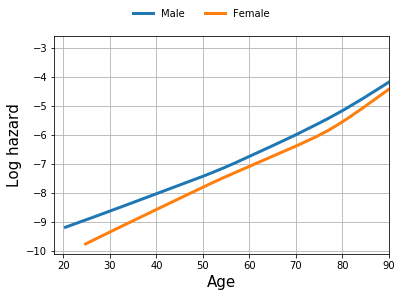

In [9]:
plt.grid(True)
sex = {0: "Male", 1: "Female"}
for female in (0, 1):
    ii = df.female == female
    s = sm.SurvfuncRight(df.loc[ii, "end"], df.loc[ii, "mortstat"], entry=df.loc[ii, "age_int"])
    tm, hz = hazard(s)
    ha = sm.nonparametric.lowess(np.log(hz), tm/12)
    plt.plot(ha[:, 0], ha[:, 1], lw=3, label=sex[female])
ha, lb = plt.gca().get_legend_handles_labels()
leg = plt.figlegend(ha, lb, "upper center", ncol=2)
leg.draw_frame(False)
plt.xlabel("Age", size=15)
plt.ylabel("Log hazard", size=15)
_ = plt.xlim(18, 90)

Fit a proportional hazards regression model, using sex, urbanicity, and
poverty status to explain the variation in life span.

In [10]:
fml = "end ~ female + rural + C(region) + poverty"
model1 = sm.PHReg.from_formula(fml, status="mortstat", entry=df.age_int,
                               data=df)
result1 = model1.fit()
print(result1.summary())

                           Results: PHReg
Model:                       PH Reg         Sample size:        7361
Dependent variable:          end            Num. events:        2105
Ties:                        Breslow                                
--------------------------------------------------------------------
                log HR log HR SE   HR      t    P>|t|  [0.025 0.975]
--------------------------------------------------------------------
C(region)[T.2]  0.0879    0.0669 1.0919  1.3138 0.1889 0.9577 1.2449
C(region)[T.3]  0.0341    0.0664 1.0347  0.5134 0.6077 0.9084 1.1785
C(region)[T.4] -0.0493    0.0573 0.9519 -0.8614 0.3890 0.8508 1.0649
female         -0.3856    0.0442 0.6800 -8.7196 0.0000 0.6236 0.7416
rural          -0.0089    0.0685 0.9911 -0.1303 0.8963 0.8666 1.1335
poverty        -0.1044    0.0128 0.9009 -8.1307 0.0000 0.8785 0.9238
Confidence intervals are for the hazard ratios
7361 observations have positive entry times


Fit the same model as above, not stratifying by state of residence.

In [11]:
fml = "end ~ female + rural + C(region) + poverty"
model2 = sm.PHReg.from_formula(fml, status="mortstat", entry=df.age_int,
                               strata=df.state, data=df)
result2 = model2.fit()
print(result2.summary())

                           Results: PHReg
Model:                     PH Reg       Num strata:            8    
Dependent variable:        end          Min stratum size:      154  
Ties:                      Breslow      Max stratum size:      3612 
Sample size:               7320         Avg stratum size:      920.1
Num. events:               2105                                     
--------------------------------------------------------------------
                log HR log HR SE   HR      t    P>|t|  [0.025 0.975]
--------------------------------------------------------------------
C(region)[T.2]  0.0499    0.1093 1.0512  0.4565 0.6480 0.8485 1.3023
C(region)[T.3]  0.0143    0.1236 1.0144  0.1161 0.9076 0.7962 1.2925
C(region)[T.4] -0.0352    0.0688 0.9654 -0.5109 0.6094 0.8436 1.1049
female         -0.3946    0.0447 0.6740 -8.8328 0.0000 0.6175 0.7356
rural          -0.0190    0.0798 0.9812 -0.2376 0.8122 0.8391 1.1474
poverty        -0.1056    0.0131 0.8998 -8.0428 0.0000 0.8769

Now stratify instead on county.  Note that the sex and poverty coefficients
are similar to what we saw above, but the urbanicity coefficient (rural)
changes substantially.  Below, we compare people living in rural areas to
people living in non-rural areas, while living in the same county.  Above,
we compare people living in rural areas to people living in non-rural areas
without the requirement that they live in the same county.

In [12]:
fml = "end ~ female + rural + C(region) + poverty"
model3 = sm.PHReg.from_formula(fml, status="mortstat", entry=df.age_int,
                               strata=df.county, data=df)
result3 = model3.fit()
print(result3.summary())

                           Results: PHReg
Model:                     PH Reg       Num strata:            31   
Dependent variable:        end          Min stratum size:      126  
Ties:                      Breslow      Max stratum size:      937  
Sample size:               7169         Avg stratum size:      237.5
Num. events:               2105                                     
--------------------------------------------------------------------
                log HR log HR SE   HR      t    P>|t|  [0.025 0.975]
--------------------------------------------------------------------
C(region)[T.2]  0.3164    0.2159 1.3722  1.4658 0.1427 0.8988 2.0949
C(region)[T.3] -0.1490    0.1716 0.8616 -0.8682 0.3853 0.6156 1.2060
C(region)[T.4] -0.1837    0.2080 0.8322 -0.8831 0.3772 0.5536 1.2510
female         -0.4137    0.0457 0.6612 -9.0492 0.0000 0.6045 0.7232
rural           0.5815    0.3195 1.7887  1.8199 0.0688 0.9562 3.3459
poverty        -0.1115    0.0138 0.8945 -8.0980 0.0000 0.8707